<a href="https://colab.research.google.com/github/sungkim11/forecast-sales/blob/main/forecast_sales_using_prophet_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecast Sales Using Prophet with Logistic Growth

## 1. Prequisites

Following are prerequisite software for this tutorial:

- Data
- Python Package: fbprophet or Facebook Prophet

### 1.1. Data

Four data sources were used for this tutorial where United Stated Census Bureau Monthly Retail Sales is used to forecast future sales, both FRED Data and OECD Data were used as Regressors data, and Monthly Retail Sales +/- 10% on annual basis was used as cap and floor.

**United Stated Census Bureau Monthly Retail Sales**<BR>
United Stated Census Bureau maintains Monthly Retail Trade Report, from January 1992 to Present. This data was picked to illustrate forecasting because it has extensive historical data with same monthly frequency. Data is available as Excel spreadsheet format at https://www.census.gov/retail/mrts/www/mrtssales92-present.xls

**FRED Data: https://fred.stlouisfed.org/**
- Inflation
- CPI
- M1
- M2
- Interest Rate

**OECD Data: https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart**
- Composite leading indicator (CLI)
- Business confidence index (BCI)
- Consumer confidence index (CCI)

**Cap and Floor**: On a calendar year basis, max retail sales + 10% was used as a CAP and min retail sales - 10% was used as a FLOOR.

### 1.2. Python Packages

#### 1.2.1. Install Prophet

**Please note that you only need to run install once.**

In [ ]:
!pip install pystan==2.19.1.1

In [ ]:
!pip install fbprophet

## 2. Code

#### 2.1. Import Python Package

Import python packages so python can use them and show its version. Showing version is important since it will enable other users to replicate your work using same python version and python packages version.

In [4]:
import matplotlib as plt
import platform

import pandas as pd
from pandas.tseries.offsets import MonthBegin
from pandas.tseries.offsets import MonthEnd

import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('matplotlib: ', plt.__version__)
print('Prophet: ', fbprophet.__version__)
print('statsmodels: ', statsmodels.__version__)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Python:  3.7.13
pandas:  1.3.5
matplotlib:  3.2.2
Prophet:  0.7.1
statsmodels:  0.10.2


#### 2.2. Mount Storage

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.3. Exploratory Data Analysis

#### Import and validate dataset

In [5]:
retail_sales_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/forecast-sales/data/mrtssales92-present-logistic.csv', index_col = 0)
retail_sales_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 1/1/2005 to 1/1/2022
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales_total     205 non-null    int64  
 1   inflation_rate  205 non-null    float64
 2   cpi             205 non-null    float64
 3   m1              205 non-null    float64
 4   m2              205 non-null    float64
 5   cli             205 non-null    float64
 6   bci             205 non-null    float64
 7   cci             205 non-null    float64
 8   cap             205 non-null    int64  
 9   floor           205 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 17.6+ KB


In [6]:
retail_sales_all.head(5)

,sales_total,inflation_rate,cpi,m1,m2,cli,bci,cci,cap,floor
month,,,,,,,,,,
1/1/2005,293261,2.53,199.0,1374.7,6406.1,100.2392,103.5195,101.0167,446169,263935
2/1/2005,295062,2.48,199.4,1355.0,6404.6,100.2278,103.3132,100.9915,446169,263935
3/1/2005,339141,2.69,200.1,1374.7,6462.9,100.1927,103.1299,100.8536,446169,263935
4/1/2005,335632,2.69,200.2,1370.8,6517.4,100.1402,103.0560,100.7005,446169,263935
5/1/2005,345348,2.60,200.5,1374.0,6453.0,100.0809,103.0645,100.6352,446169,263935


#### Convert month date to month-end because of fbprophet's use of month-end date.

In [7]:
retail_sales_all.reset_index(inplace = True)
retail_sales_all['month'] = pd.to_datetime(retail_sales_all['month']) + MonthEnd(1)
retail_sales_all.set_index(['month'], inplace = True)
retail_sales_all.index = pd.to_datetime(retail_sales_all.index)
retail_sales_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2005-01-31 to 2022-01-31
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales_total     205 non-null    int64  
 1   inflation_rate  205 non-null    float64
 2   cpi             205 non-null    float64
 3   m1              205 non-null    float64
 4   m2              205 non-null    float64
 5   cli             205 non-null    float64
 6   bci             205 non-null    float64
 7   cci             205 non-null    float64
 8   cap             205 non-null    int64  
 9   floor           205 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 17.6 KB


In [8]:
retail_sales_all.head(5)

,sales_total,inflation_rate,cpi,m1,m2,cli,bci,cci,cap,floor
month,,,,,,,,,,
2005-01-31,293261,2.53,199.0,1374.7,6406.1,100.2392,103.5195,101.0167,446169,263935
2005-02-28,295062,2.48,199.4,1355.0,6404.6,100.2278,103.3132,100.9915,446169,263935
2005-03-31,339141,2.69,200.1,1374.7,6462.9,100.1927,103.1299,100.8536,446169,263935
2005-04-30,335632,2.69,200.2,1370.8,6517.4,100.1402,103.0560,100.7005,446169,263935
2005-05-31,345348,2.60,200.5,1374.0,6453.0,100.0809,103.0645,100.6352,446169,263935


#### Slice Datasets

Slice datasets to sales data and regressor data:
- Sales Data: Date and Sales Total
- Regressors: inflation rate, cpi, m1, m2, cli, bci, and cci

In [9]:
retail_sales = retail_sales_all.filter(["month","sales_total"])
retail_sales.head()

,sales_total
month,
2005-01-31,293261
2005-02-28,295062
2005-03-31,339141
2005-04-30,335632
2005-05-31,345348


In [10]:
retail_sales_regressors = retail_sales_all.filter(["month", "inflation_rate", "cpi", "m1", "m2", "cli", "bci", "cci", "cap", "floor"])
retail_sales_regressors.head()

,inflation_rate,cpi,m1,m2,cli,bci,cci,cap,floor
month,,,,,,,,,
2005-01-31,2.53,199.0,1374.7,6406.1,100.2392,103.5195,101.0167,446169,263935
2005-02-28,2.48,199.4,1355.0,6404.6,100.2278,103.3132,100.9915,446169,263935
2005-03-31,2.69,200.1,1374.7,6462.9,100.1927,103.1299,100.8536,446169,263935
2005-04-30,2.69,200.2,1370.8,6517.4,100.1402,103.0560,100.7005,446169,263935
2005-05-31,2.60,200.5,1374.0,6453.0,100.0809,103.0645,100.6352,446169,263935


#### Split Datasets

Split datasets:
- Actuals
- Train
- Test
- Validate
- Cross Validate

In [11]:
retail_sales_actuals = retail_sales.loc['2005-01-01':'2018-12-31']
retail_sales_train = retail_sales.loc['2005-01-01':'2016-12-31']
retail_sales_test = retail_sales.loc['2017-01-01':'2018-12-31']
retail_sales_traintest = retail_sales.loc['2005-01-01':'2018-12-31']
retail_sales_validate = retail_sales.loc['2019-01-01':'2021-12-31']
retail_sales_cross_validate = retail_sales.loc['2017-01-01':'2021-12-31']

print('Actuals: ', retail_sales_actuals.shape)
print('Train: ', retail_sales_train.shape)
print('Test: ', retail_sales_test.shape)
print('Train and Test: ', retail_sales_traintest.shape)
print('Validate: ', retail_sales_validate.shape)
print('Cross Validate: ', retail_sales_cross_validate.shape)

Actuals:  (168, 1)
Train:  (144, 1)
Test:  (24, 1)
Train and Test:  (168, 1)
Validate:  (36, 1)
Cross Validate:  (60, 1)


#### Set Plotting Parameters

In [12]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 30
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

#### Chart Retail Sales

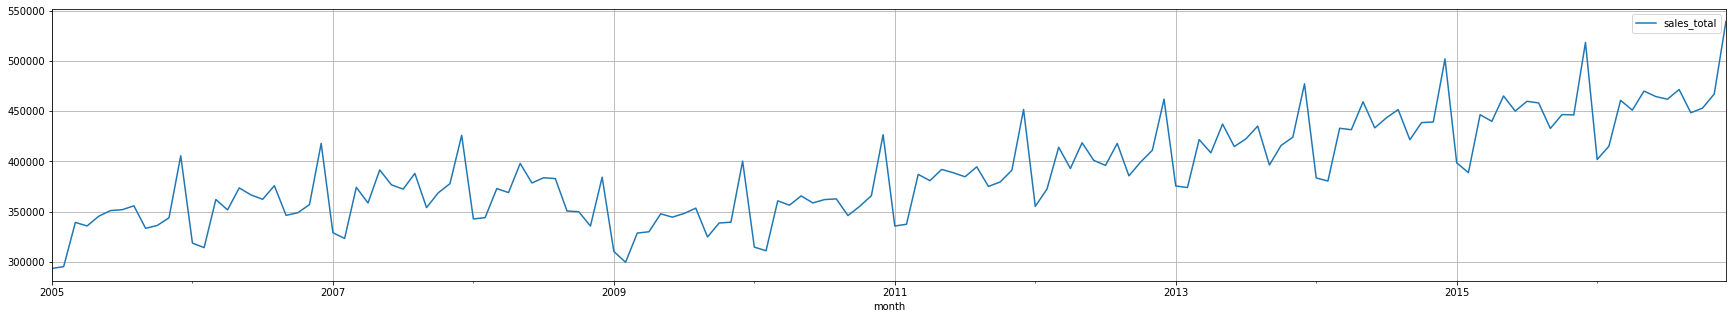

In [13]:
retail_sales_train.reset_index().plot(x='month', y='sales_total', kind='line', grid=1)
plt.pyplot.show()

#### Determine Retail Sales Data (Time-Series) has trend

Next, we need to determine if the retail sales data is non-stationary or it has trends using Dickey Fuller Test, which is a statistical hypothesis test that allows you to detect non-stationarity. The stationary time-series implies there is no predictable pattern in the long term.

In [14]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(retail_sales_train.sales_total.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -0.41114662261582896
ADF p-values: 0.9082209893408628
ADF number of lags used: 14
ADF number of observations: 129
ADF critical values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}
ADF best information criterion: 2712.938864098956


Looking at the value, which is bigger than 0.05, you can determine time-series data is non-stationary.

#### Decompose Retail Sales to Determine Which Model to Use

Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem.

Multiplicative Model Analysis

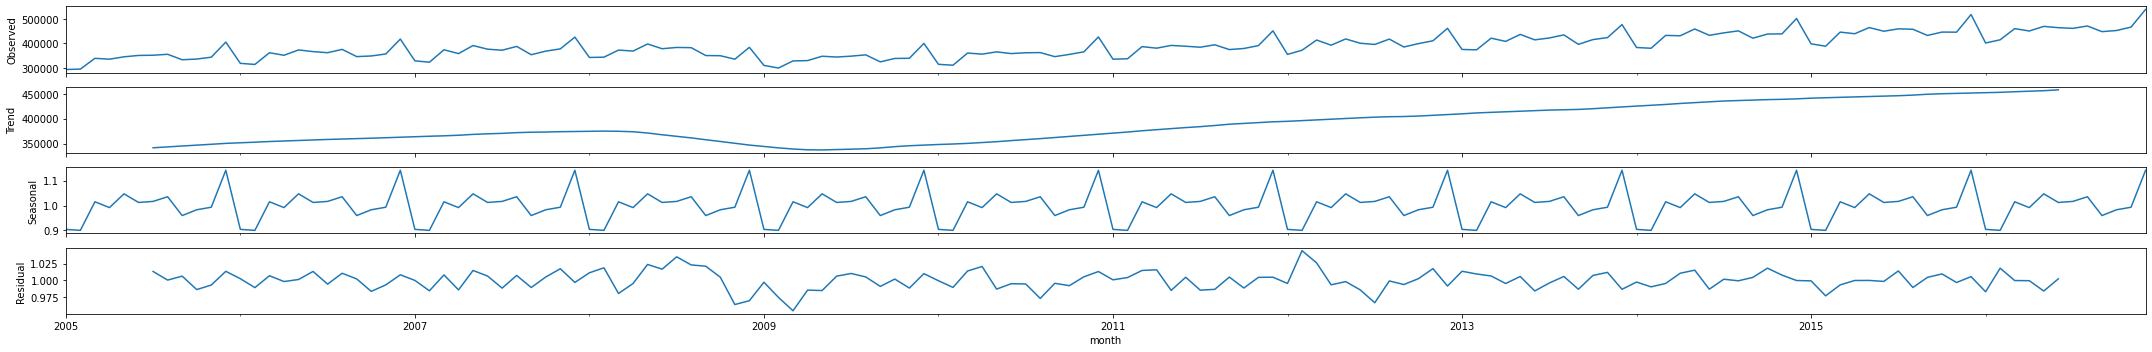

In [15]:
retail_sales_train.index = pd.to_datetime(retail_sales_train.index)
retail_sales_train_decompose_multi = seasonal_decompose(retail_sales_train, model='multiplicative')
retail_sales_train_decompose_multi.plot().show()

In [16]:
retail_sales_train_decompose_multi_resid = retail_sales_train_decompose_multi.resid.sum()
retail_sales_train_decompose_multi_resid.sales_total

132.00368387124905

Additive Model Analysis

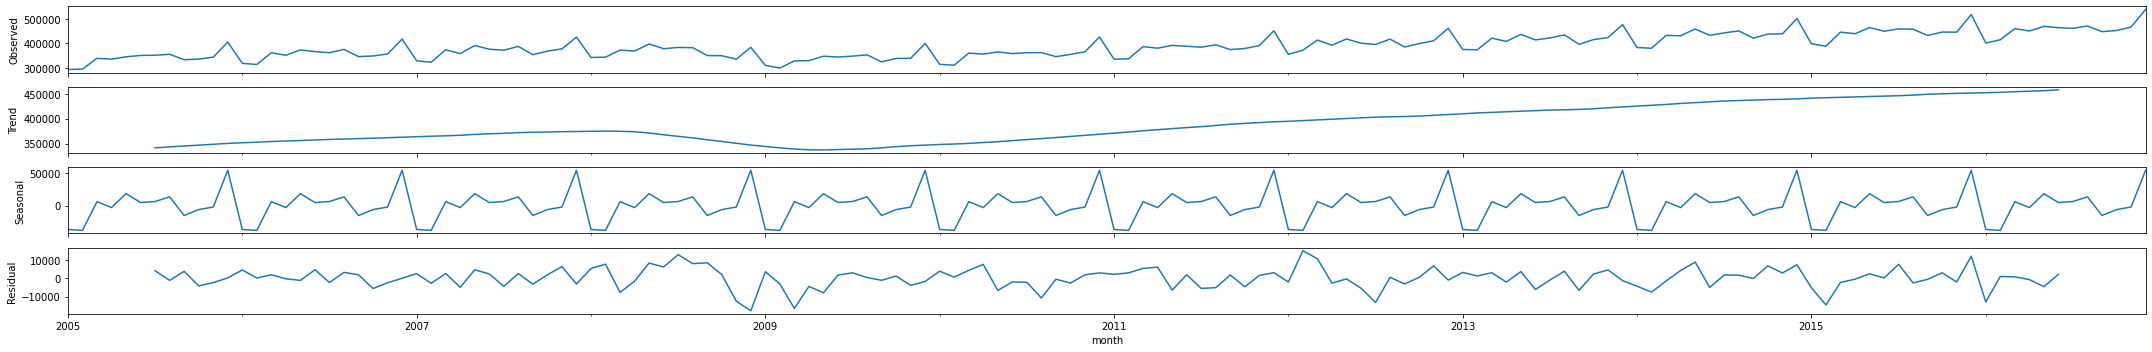

In [17]:
retail_sales_train_decompose_add = seasonal_decompose(retail_sales_train, model='additive')
retail_sales_train_decompose_add.plot().show()

In [18]:
retail_sales_train_decompose_add_resid = retail_sales_train_decompose_add.resid.sum()
retail_sales_train_decompose_add_resid.sales_total

4523.166666669258

Looking at Residual chart, multiplicative chart is smoother, so we will use multiplicative model, but just check programatically compare simple sum of residual values.

In [19]:
if retail_sales_train_decompose_multi_resid.values < retail_sales_train_decompose_add_resid.values:
    print("Multiplicate  Model")
else:
    print("Additive  Model")

Multiplicate  Model


#### Prep Train Dataset

In [20]:
retail_sales_regressors = retail_sales_regressors.reset_index()
retail_sales_train = retail_sales_train.merge(retail_sales_regressors, on='month', how='left')
retail_sales_train.head()

,month,sales_total,inflation_rate,cpi,m1,m2,cli,bci,cci,cap,floor
0,2005-01-31,293261,2.53,199.0,1374.7,6406.1,100.2392,103.5195,101.0167,446169,263935
1,2005-02-28,295062,2.48,199.4,1355.0,6404.6,100.2278,103.3132,100.9915,446169,263935
2,2005-03-31,339141,2.69,200.1,1374.7,6462.9,100.1927,103.1299,100.8536,446169,263935
3,2005-04-30,335632,2.69,200.2,1370.8,6517.4,100.1402,103.0560,100.7005,446169,263935
4,2005-05-31,345348,2.60,200.5,1374.0,6453.0,100.0809,103.0645,100.6352,446169,263935


In [21]:
retail_sales_train.columns = ['ds', 'y', 'inflation', 'cpi', 'm1', 'm2', 'cli', 'bci', 'cci', 'cap', 'floor']
retail_sales_train.head()

,ds,y,inflation,cpi,m1,m2,cli,bci,cci,cap,floor
0,2005-01-31,293261,2.53,199.0,1374.7,6406.1,100.2392,103.5195,101.0167,446169,263935
1,2005-02-28,295062,2.48,199.4,1355.0,6404.6,100.2278,103.3132,100.9915,446169,263935
2,2005-03-31,339141,2.69,200.1,1374.7,6462.9,100.1927,103.1299,100.8536,446169,263935
3,2005-04-30,335632,2.69,200.2,1370.8,6517.4,100.1402,103.0560,100.7005,446169,263935
4,2005-05-31,345348,2.60,200.5,1374.0,6453.0,100.0809,103.0645,100.6352,446169,263935


####Develop and Fit Forecast Model then Forecast Sales (for Test) using Forecast Model

In [22]:
#retail_sales_model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', growth='logistic')
#Logistic Growth does not work well with Multiplicative, hence the use of Additive.
retail_sales_model = Prophet(yearly_seasonality=True, seasonality_mode='additive', growth='logistic')

retail_sales_model.add_regressor('inflation')
#retail_sales_model.add_regressor('cpi')
#retail_sales_model.add_regressor('m1')
#retail_sales_model.add_regressor('m2')
retail_sales_model.add_regressor('cli')
#retail_sales_model.add_regressor('bci')
#retail_sales_model.add_regressor('cci')

retail_sales_model.fit(retail_sales_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
retail_sales_future = retail_sales_model.make_future_dataframe(freq='M', periods=24)
retail_sales_future.head(5)

,ds
0,2005-01-31
1,2005-02-28
2,2005-03-31
3,2005-04-30
4,2005-05-31


In [24]:
retail_sales_regressors.head()

,month,inflation_rate,cpi,m1,m2,cli,bci,cci,cap,floor
0,2005-01-31,2.53,199.0,1374.7,6406.1,100.2392,103.5195,101.0167,446169,263935
1,2005-02-28,2.48,199.4,1355.0,6404.6,100.2278,103.3132,100.9915,446169,263935
2,2005-03-31,2.69,200.1,1374.7,6462.9,100.1927,103.1299,100.8536,446169,263935
3,2005-04-30,2.69,200.2,1370.8,6517.4,100.1402,103.0560,100.7005,446169,263935
4,2005-05-31,2.60,200.5,1374.0,6453.0,100.0809,103.0645,100.6352,446169,263935


In [25]:
retail_sales_regressors.columns = ['ds', 'inflation', 'cpi', 'm1', 'm2', 'cli', 'bci', 'cci', 'cap', 'floor']
retail_sales_future = retail_sales_future.merge(retail_sales_regressors, on='ds', how='left')
retail_sales_future.tail(5)

,ds,inflation,cpi,m1,m2,cli,bci,cci,cap,floor
163,2018-08-31,2.13,258.028,3664.8,14179.0,99.08091,99.29861,101.1488,612275,391836
164,2018-09-30,2.08,258.505,3678.4,14217.2,98.69699,99.12753,101.0597,612275,391836
165,2018-10-31,2.14,258.997,3727.4,14218.7,98.31645,98.99612,100.9435,612275,391836
166,2018-11-30,2.02,259.455,3664.2,14260.9,97.96261,98.88857,100.8148,612275,391836
167,2018-12-31,1.97,259.934,3814.2,14452.3,97.66416,98.78981,100.7151,612275,391836


In [26]:
retail_sales_forecast = retail_sales_model.predict(retail_sales_future)
retail_sales_forecast.tail(5)

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,inflation,inflation_lower,inflation_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
163,2018-08-31,492381.718747,612275,391836,496332.937538,515408.856968,492326.866864,492440.584338,13080.720645,13080.720645,...,345.590826,345.590826,345.590826,12354.480044,12354.480044,12354.480044,0.0,0.0,0.0,505462.439392
164,2018-09-30,492438.469243,612275,391836,469354.783825,488478.665182,492379.142613,492502.939977,-13428.897985,-13428.897985,...,-111.808797,-111.808797,-111.808797,-13826.965501,-13826.965501,-13826.965501,0.0,0.0,0.0,479009.571259
165,2018-10-31,492497.116821,612275,391836,480927.800211,499279.886777,492433.077871,492566.368998,-2290.474028,-2290.474028,...,437.070751,437.070751,437.070751,-3365.509930,-3365.509930,-3365.509930,0.0,0.0,0.0,490206.642793
166,2018-11-30,492553.877734,612275,391836,484620.276933,504041.288227,492484.307122,492628.334052,2154.832740,2154.832740,...,-660.688344,-660.688344,-660.688344,2058.454250,2058.454250,2058.454250,0.0,0.0,0.0,494708.710474
167,2018-12-31,492612.536012,612275,391836,545641.587279,565188.829222,492537.327272,492691.526733,62414.618814,62414.618814,...,-1118.087967,-1118.087967,-1118.087967,62675.182402,62675.182402,62675.182402,0.0,0.0,0.0,555027.154826


####Chart Sales Forecast

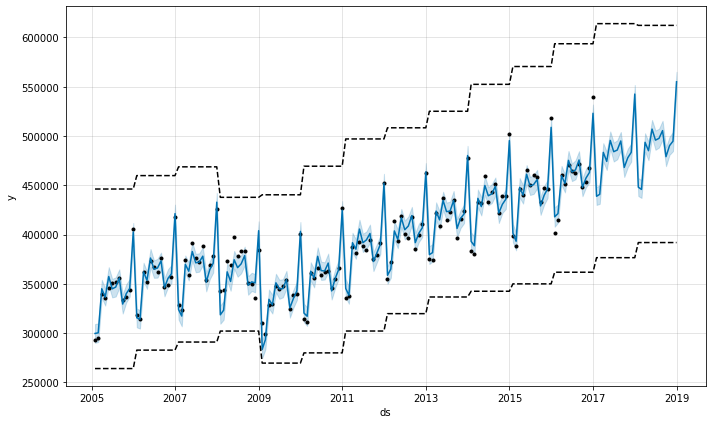

In [27]:
retail_sales_model.plot(retail_sales_forecast).show()

####Chart Sales Forecast Components

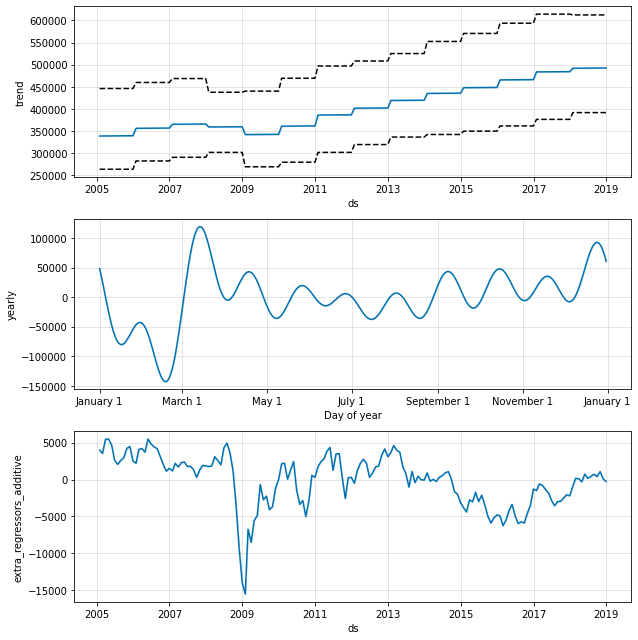

In [28]:
retail_sales_model.plot_components(retail_sales_forecast).show()

####Validate Sales Forecast - Prophet Validation Method

In [29]:
retail_sales_cv = cross_validation(retail_sales_model, initial = '1825 days', period='365 days', horizon='2190 days', parallel='processes')
retail_sales_cv.tail(5)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2011-01-02 00:00:00 and 2011-01-02 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6f26062450>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
67,2016-08-31,479443.025673,469464.778570,488860.011828,471690,2011-01-02
68,2016-09-30,455634.336535,445794.798522,465902.552738,448516,2011-01-02
69,2016-10-31,464792.140122,455543.698694,474245.976221,453155,2011-01-02
70,2016-11-30,461769.014735,452482.585439,471256.775912,467232,2011-01-02
71,2016-12-31,526059.858672,516077.998179,535845.985148,539667,2011-01-02


In [30]:
retail_sales_p = performance_metrics(retail_sales_cv)
retail_sales_p.tail(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
61,2068 days,1.157959e+08,10760.851973,9172.451764,0.020451,0.020363,0.571429
62,2098 days,7.501636e+07,8661.198752,7570.244676,0.016409,0.016437,0.714286
63,2129 days,9.434826e+07,9713.302995,9187.565017,0.019980,0.020363,0.571429
64,2159 days,8.655675e+07,9303.587767,8655.688817,0.018741,0.016437,0.571429
65,2190 days,9.754886e+07,9876.682639,9113.511979,0.019182,0.016437,0.571429


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


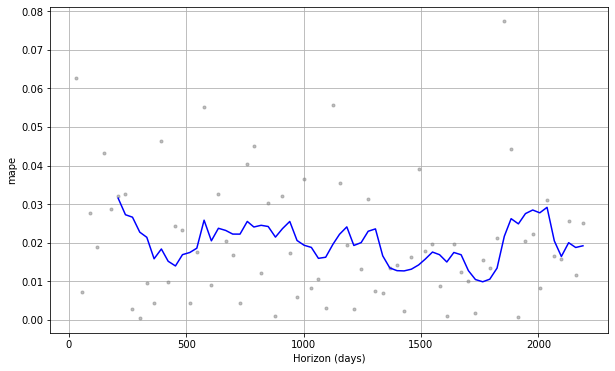

In [31]:
fig = plot_cross_validation_metric(retail_sales_cv, metric='mape')

In [32]:
retail_sales_p.mean()

horizon     1199 days 18:10:54.545454544
mse                     104768974.167852
rmse                         9943.398366
mae                          8194.680389
mape                            0.019905
mdape                           0.017113
coverage                        0.658009
dtype: object

####Validate Sales Forecast - Forecast All Methods

In [33]:
retail_sales_forecast_filtered = retail_sales_forecast.filter(["ds","yhat"])
retail_sales_forecast_filtered.head(5)

,ds,yhat
0,2005-01-31,299548.007281
1,2005-02-28,300220.389785
2,2005-03-31,344935.695369
3,2005-04-30,336356.624667
4,2005-05-31,357346.412250


In [34]:
retail_sales_forecast_filtered.columns = ['Month', 'Prediction']
retail_sales_forecast_filtered = retail_sales_forecast_filtered.set_index('Month')
retail_sales_validate = pd.DataFrame(retail_sales_forecast_filtered, index =retail_sales_test.index, columns=['Prediction'])
retail_sales_validate = pd.concat([retail_sales_test, retail_sales_validate], axis=1)
retail_sales_validate.head(5)

,sales_total,Prediction
month,,
2017-01-31,421943,438798.639011
2017-02-28,418315,440810.417601
2017-03-31,483082,483383.965437
2017-04-30,465788,474213.021622
2017-05-31,494621,495518.012486


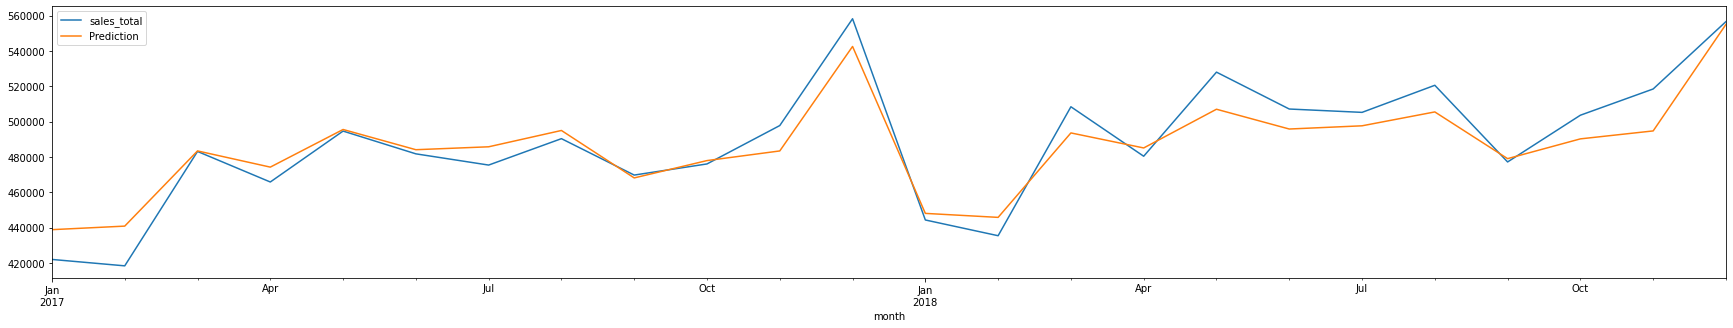

In [35]:
retail_sales_validate.plot()
plt.pyplot.show()

In [36]:
retail_sales_validate['Abs Diff'] = (retail_sales_validate['sales_total'] - retail_sales_validate['Prediction']).abs()
retail_sales_validate['Abs Diff %'] = (retail_sales_validate['sales_total'] - retail_sales_validate['Prediction']).abs()/retail_sales_validate['sales_total']
retail_sales_validate.loc['Average Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].mean(), index = ['Abs Diff %'])
retail_sales_validate.loc['Min Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].min(), index = ['Abs Diff %'])
retail_sales_validate.loc['Max Abs Diff %'] = pd.Series(retail_sales_validate['Abs Diff %'].max(), index = ['Abs Diff %'])
retail_sales_validate.tail(5)

,sales_total,Prediction,Abs Diff,Abs Diff %
month,,,,
2018-11-30 00:00:00,518457.0,494708.710474,23748.289526,0.045806
2018-12-31 00:00:00,556614.0,555027.154826,1586.845174,0.002851
Average Abs Diff %,NaN,NaN,NaN,0.019633
Min Abs Diff %,NaN,NaN,NaN,0.000625
Max Abs Diff %,NaN,NaN,NaN,0.053776


####Forecast Sales All using same Forecast Model

Using same forecast model, forecast sales for all months till Deceomber 2021.

In [37]:
retail_sales_future_all = retail_sales_model.make_future_dataframe(freq='M', periods=60)

In [38]:
retail_sales_future_all = retail_sales_future_all.merge(retail_sales_regressors, on='ds', how='left')
retail_sales_future_all.head(5)

,ds,inflation,cpi,m1,m2,cli,bci,cci,cap,floor
0,2005-01-31,2.53,199.0,1374.7,6406.1,100.2392,103.5195,101.0167,446169,263935
1,2005-02-28,2.48,199.4,1355.0,6404.6,100.2278,103.3132,100.9915,446169,263935
2,2005-03-31,2.69,200.1,1374.7,6462.9,100.1927,103.1299,100.8536,446169,263935
3,2005-04-30,2.69,200.2,1370.8,6517.4,100.1402,103.0560,100.7005,446169,263935
4,2005-05-31,2.60,200.5,1374.0,6453.0,100.0809,103.0645,100.6352,446169,263935


In [39]:
retail_sales_forecast_all = retail_sales_model.predict(retail_sales_future_all)
retail_sales_forecast_all.tail(5)

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,inflation,inflation_lower,inflation_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
199,2021-08-31,599909.523339,781681,441581,606631.748333,625909.234118,599446.699434,600311.207938,16294.593546,16294.593546,...,2815.548790,2815.548790,2815.548790,13858.933821,13858.933821,13858.933821,0.0,0.0,0.0,616204.116885
200,2021-09-30,599997.339345,781681,441581,579219.253330,598294.904161,599524.576168,600409.998200,-11199.590424,-11199.590424,...,2266.669242,2266.669242,2266.669242,-13082.634369,-13082.634369,-13082.634369,0.0,0.0,0.0,588797.748921
201,2021-10-31,600088.089101,781681,441581,589160.695061,608050.872548,599605.315676,600507.253184,-1574.394887,-1574.394887,...,2632.588940,2632.588940,2632.588940,-3827.027443,-3827.027443,-3827.027443,0.0,0.0,0.0,598513.694215
202,2021-11-30,600175.917736,781681,441581,595935.811217,613302.295000,599682.858364,600597.219440,4527.667024,4527.667024,...,3730.348035,3730.348035,3730.348035,1163.070955,1163.070955,1163.070955,0.0,0.0,0.0,604703.584760
203,2021-12-31,600266.680442,781681,441581,654033.131254,673306.231322,599762.220798,600697.240892,63239.965697,63239.965697,...,3181.468488,3181.468488,3181.468488,60394.224672,60394.224672,60394.224672,0.0,0.0,0.0,663506.646138


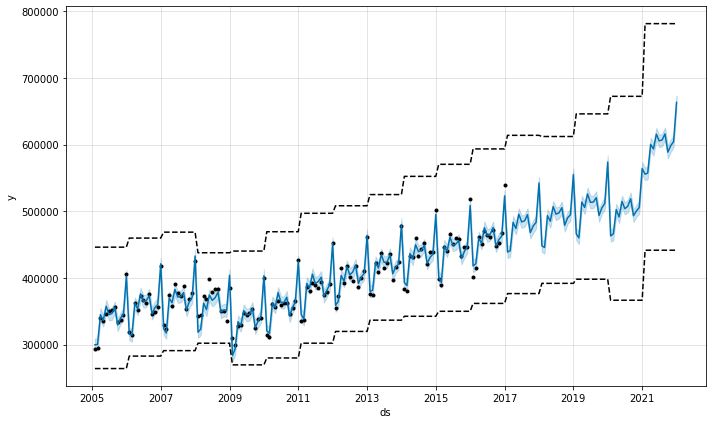

In [40]:
retail_sales_model.plot(retail_sales_forecast_all).show()

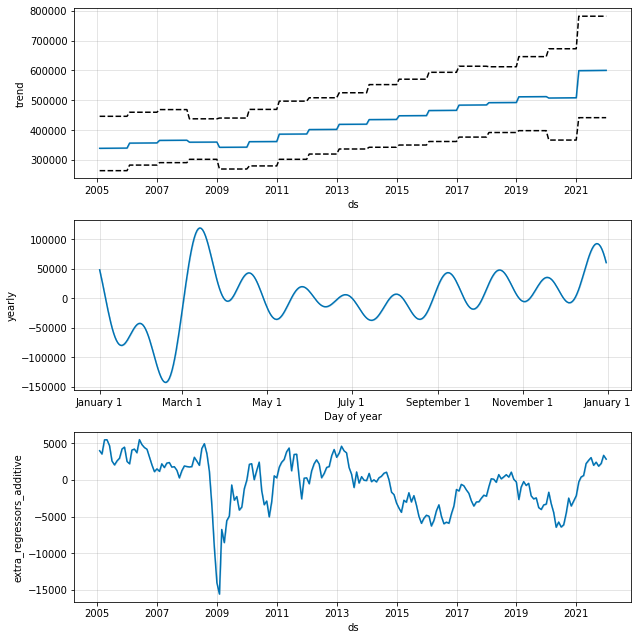

In [41]:
retail_sales_model.plot_components(retail_sales_forecast_all).show()

####Validate Sales All Forecast - All Forecast Methodology

Please note that forecast will not perform well for both calendar year 2020 and 2021.

In [42]:
retail_sales_forecast_all_filtered = retail_sales_forecast_all.filter(["ds","yhat"])
retail_sales_forecast_all_filtered.head(5)

,ds,yhat
0,2005-01-31,299548.007281
1,2005-02-28,300220.389785
2,2005-03-31,344935.695369
3,2005-04-30,336356.624667
4,2005-05-31,357346.412250


In [43]:
retail_sales_forecast_all_filtered.columns = ['Month', 'Prediction']
retail_sales_forecast_all_filtered = retail_sales_forecast_all_filtered.set_index('Month')

retail_sales_validate_all = pd.DataFrame(retail_sales_forecast_all_filtered, index =retail_sales_cross_validate.index, columns=['Prediction'])
retail_sales_validate_all = pd.concat([retail_sales_cross_validate, retail_sales_validate_all], axis=1)
retail_sales_validate_all.head(5)

,sales_total,Prediction
month,,
2017-01-31,421943,438798.639011
2017-02-28,418315,440810.417601
2017-03-31,483082,483383.965437
2017-04-30,465788,474213.021622
2017-05-31,494621,495518.012486


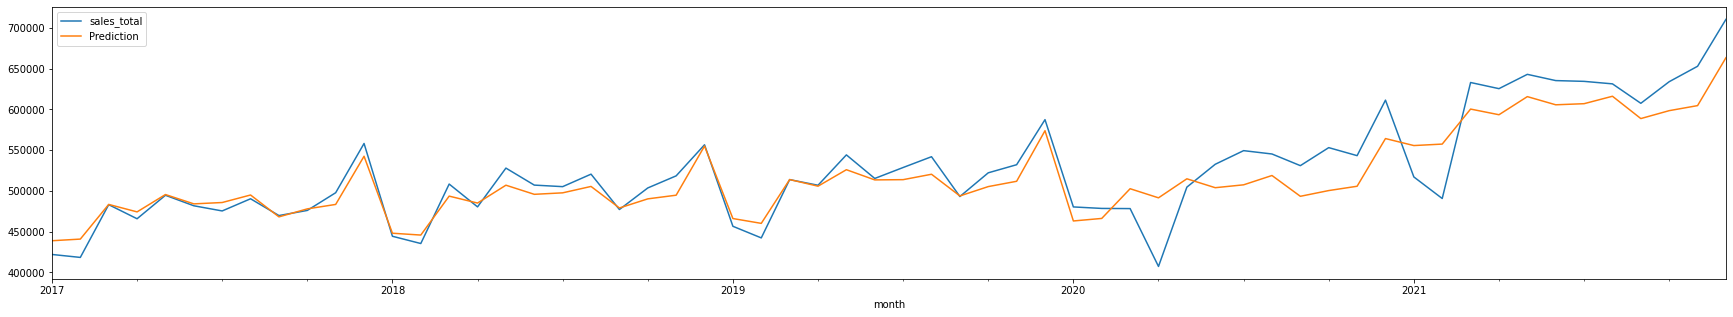

In [44]:
retail_sales_validate_all.plot()
plt.pyplot.show()

In [45]:
retail_sales_validate_all['Abs Diff'] = (retail_sales_validate_all['sales_total'] - retail_sales_validate_all['Prediction']).abs()
retail_sales_validate_all['Abs Diff %'] = (retail_sales_validate_all['sales_total'] - retail_sales_validate_all['Prediction']).abs()/retail_sales_validate_all['sales_total']
retail_sales_validate_all.loc['Average Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].mean(), index = ['Abs Diff %'])
retail_sales_validate_all.loc['Min Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].min(), index = ['Abs Diff %'])
retail_sales_validate_all.loc['Max Abs Diff %'] = pd.Series(retail_sales_validate_all['Abs Diff %'].max(), index = ['Abs Diff %'])
retail_sales_validate_all.tail(10)

,sales_total,Prediction,Abs Diff,Abs Diff %
month,,,,
2021-06-30 00:00:00,635437.0,605714.546833,29722.453167,0.046775
2021-07-31 00:00:00,634486.0,607064.798407,27421.201593,0.043218
2021-08-31 00:00:00,631415.0,616204.116885,15210.883115,0.024090
2021-09-30 00:00:00,607540.0,588797.748921,18742.251079,0.030849
2021-10-31 00:00:00,634076.0,598513.694215,35562.305785,0.056085
2021-11-30 00:00:00,653011.0,604703.584760,48307.415240,0.073976
2021-12-31 00:00:00,710619.0,663506.646138,47112.353862,0.066298
Average Abs Diff %,NaN,NaN,NaN,0.037719
Min Abs Diff %,NaN,NaN,NaN,0.000124
